In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import math
import pickle
from Utils.validation_callback import AdditionalValidationSets

In [2]:
with open ('Data/Players', 'rb') as fp:
    players = pickle.load(fp)
with open ('Data/Venue', 'rb') as fp:
    venue = pickle.load(fp)
with open ('Data/Teams', 'rb') as fp:
    teams = pickle.load(fp)
# with open ('Data/BF_Cols', 'rb') as fp:
#     BF_Cols = pickle.load(fp)
# with open ('Data/BS_Cols', 'rb') as fp:
#     BS_Cols = pickle.load(fp)

In [3]:
def get_onehot(df):
    # df1=pd.get_dummies(df.Toss, prefix="Toss")
    # col = "Toss_"
    # df_columns = set(df[col[:-1]])
    # not_there = list(set(teams)-df_columns)
    # data = np.zeros((df.shape[0], len(not_there)))
    # df_add = pd.DataFrame(data=data, columns=[col+i for i in not_there])
    # df1 = pd.concat([df1, df_add], axis=1)

    df2=pd.get_dummies(df.Venue,prefix="Venue")
    col = "Venue_"
    df_columns = set(df[col[:-1]])
    not_there = list(set(venue)-df_columns)
    data = np.zeros((df.shape[0], len(not_there)))
    df_add = pd.DataFrame(data=data, columns=[col+i for i in not_there])
    df2 = pd.concat([df2, df_add], axis=1)

    df3=pd.get_dummies(df.Batting_Team, prefix="Batting_Team")
    col = "Batting_Team_"
    df_columns = set(df[col[:-1]])
    not_there = list(set(teams)-df_columns)
    data = np.zeros((df.shape[0], len(not_there)))
    df_add = pd.DataFrame(data=data, columns=[col+i for i in not_there])
    df3 = pd.concat([df3, df_add], axis=1)

    df4=pd.get_dummies(df.Bowling_Team, prefix="Bowling_Team")
    col = "Bowling_Team_"
    df_columns = set(df[col[:-1]])
    not_there = list(set(teams)-df_columns)
    data = np.zeros((df.shape[0], len(not_there)))
    df_add = pd.DataFrame(data=data, columns=[col+i for i in not_there])
    df4 = pd.concat([df4, df_add], axis=1)

    df5=pd.get_dummies(df.Striker, prefix="Striker")
    df5_columns = set(df["Striker"])
    never_striker= list(set(players)-df5_columns)
    data = np.zeros((df.shape[0], len(never_striker)))
    df5_add = pd.DataFrame(data=data, columns=["Striker_"+i for i in never_striker])
    df5 = pd.concat([df5, df5_add], axis=1)

    df6=pd.get_dummies(df.Non_Striker, prefix="Non_Striker")
    df6_columns = set(df["Non_Striker"])
    never_non_striker= list(set(players)-df6_columns)
    data = np.zeros((df.shape[0], len(never_non_striker)))
    df6_add = pd.DataFrame(data=data, columns=["Non_Striker_"+i for i in never_non_striker])
    df6 = pd.concat([df6, df6_add], axis=1)

    df7=pd.get_dummies(df.Bowler, prefix="Bowler")
    df7_columns = set(df["Bowler"])
    never_bowler= list(set(players)-df7_columns)
    data = np.zeros((df.shape[0], len(never_bowler)))
    df7_add = pd.DataFrame(data=data, columns=["Bowler_"+i for i in never_bowler])
    df7 = pd.concat([df7, df7_add], axis=1)

    df_one_hot=df.copy(deep=True)
    # df_one_hot=pd.concat([df,df1,df2,df3,df4,df5,df6,df7], axis=1)
    df_one_hot=pd.concat([df,df2,df3,df4,df5,df6,df7], axis=1)
    df_result=pd.DataFrame(df_one_hot["Result"])
    # df_one_hot=df_one_hot.drop(columns=["Toss","Venue","Batting_Team","Bowling_Team","Striker","Non_Striker","Bowler","Result"])
    df_one_hot=df_one_hot.drop(columns=["Venue","Batting_Team","Bowling_Team","Striker","Non_Striker","Bowler","Result"])
    return df_one_hot, df_result

In [4]:
def get_cont_ids(df):
    prev = None
    start = 0
    cont_ids = []
    for ind, row in df.iterrows():
        # curr = [[row['Toss'], row['Venue'], row['Batting_Team'], row['Bowling_Team']]]
        curr = [[row['Venue'], row['Batting_Team'], row['Bowling_Team']]]
        if curr != prev and prev!=None:
            cont_ids.append([start, ind])
            start = ind
        prev = curr
    cont_ids.append([start, df.shape[0]])
    return cont_ids

def get_df_split(df):
    df_list = []
    for start, end in get_cont_ids(df):
        df_list.append(df[start:end].reset_index(drop=True))
    return df_list

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
            df: pd.DataFrame,
            window: int = 6,
            batch_size: int = 64,
            shuffle: bool = True,
            validate: bool = False,
            overs_start: int = None,
            overs_end: int = None,
            ):
        self.df = df
        self.overs_start = overs_start
        self.overs_end = overs_end
        self.window = window
        self.batch_size = batch_size
        self.inp_cols = None
        self.out_cols = None
        self.validate = validate
        self.batches = self.__fill_batches()
        self.len_dataset = len(self.batches)
        self.shuffle = shuffle
        self.on_epoch_end()


    def __shuffle(self):
        for key in self.batches:
            random.shuffle(self.batches[key])


    def __fill_getitem_batches(self):
        self.getitem_batches = []
        for key in self.batches:
            curr_size_list = self.batches[key]
            num_items = math.ceil(len(curr_size_list)/self.batch_size)
            for i in range(1, num_items + 1):
                temp = curr_size_list[(i-1)*self.batch_size: i*self.batch_size]
                inp_batch = np.array([x[0] for x in temp])
                out_batch = np.array([x[1] for x in temp])
                self.getitem_batches.append((inp_batch, out_batch))
        if self.shuffle:
            random.shuffle(self.getitem_batches)


    def __fill_batches(self):
        df_list = get_df_split(self.df)
        if self.validate:
            if self.overs_start is not None and self.overs_end is not None:
                # filter_1 = [df[df["Overs"] <= self.overs_end] for df in df_list[math.floor(0.80*len(df_list)):]]
                # filter_2 = [df[df["Overs"] >= self.overs_start] for df in filter_1]
                one_hot_lis = [get_onehot(df[np.logical_and(df["Overs"] <= self.overs_end,
                                   df["Overs"] >= self.overs_start)].reset_index(drop=True)) for df in df_list[math.floor(0.80*len(df_list)):]]
            else:
                one_hot_lis = [get_onehot(df) for df in df_list[math.floor(0.80*len(df_list)):]]
        else:
            one_hot_lis = [get_onehot(df) for df in df_list[:math.floor(0.80*len(df_list))]]
        one_hot_lis = [(inp.reindex(sorted(inp.columns), axis=1), out) for inp, out in one_hot_lis]
        batches = {}
        for i in range(1, self.window + 1):
            batches[i] = []
        for inp, out in one_hot_lis:
            inp_numpy, out_numpy = inp.values, out.values
            for end in range(inp.shape[0]):
                start = max(end - self.window + 1, 0)
                size = end - start + 1
                batches[size].append((inp_numpy[start: end + 1], out_numpy[end]))
        self.inp_cols = inp.columns.to_list()
        self.out_cols = out.columns.to_list()
        return batches


    def __len__(self):
        return len(self.getitem_batches)


    def __getitem__(self, index):
        x, y = self.getitem_batches[index]
        return x, np.reshape(y, (-1, ))


    def on_epoch_end(self):
        if self.shuffle:
            self.__shuffle()
        self.__fill_getitem_batches()

In [6]:
def create_validation_sets(df, start_ends, window_size=6, batch_size=64):
    validation_sets = []
    for (start, end) in start_ends:
        validation_sets.append(
            (DataGenerator(df, window_size, batch_size,
                          validate=True,
                          overs_start=start,
                          overs_end=end), f"Overs: {start}-{end}"))
    return validation_sets

## Batting First

In [7]:
BF = pd.read_csv("Data/Batting_First.csv")
BF_clean = BF.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BF_clean.columns)


Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Result'],
      dtype='object')


In [8]:
# BF = pd.read_csv("Data/Batting_First.csv")
window_size = 12
batch_size = 8
bf_train_gen = DataGenerator(BF_clean, window_size, batch_size)
bf_test_gen = DataGenerator(BF_clean, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BF_clean, ((1, 5), (6, 10), (11, 15), (16, 20)),
                                         window_size=window_size,
                                         batch_size=batch_size)

In [9]:
# with open('Data\BF_Cols.pkl', 'wb') as f:
#     pickle.dump(bf_train_gen.inp_cols, f)

In [11]:
model_inn_1 = tf.keras.Sequential([
  tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(None, bf_test_gen[0][0].shape[-1])),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(57, activation='softmax')
])
model_inn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         4227072   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 57)                3

In [12]:
# model_inn_1 = tf.keras.models.load_model('Models\\Inn1_SimpleRNN_10.h5')

In [13]:
start = 0
epochs = 10
validation_callback = AdditionalValidationSets(validation_sets)
model_inn_1.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_1.fit(bf_train_gen,
                validation_data=bf_test_gen,
                epochs=epochs,
                callbacks=[AdditionalValidationSets(validation_sets)] # , PlotLossesKeras()]
                )

Epoch 1/10
7638/7638 [==============================] - 475s 61ms/step - loss: 1.7628 - accuracy: 0.4165 - val_loss: 1.7320 - val_accuracy: 0.4160
Epoch 2/10
7638/7638 [==============================] - 376s 49ms/step - loss: 1.7396 - accuracy: 0.4234 - val_loss: 1.7304 - val_accuracy: 0.4171
Epoch 3/10
7638/7638 [==============================] - 310s 41ms/step - loss: 1.7361 - accuracy: 0.4241 - val_loss: 1.7340 - val_accuracy: 0.4182
Epoch 4/10
7638/7638 [==============================] - 410s 54ms/step - loss: 1.7308 - accuracy: 0.4269 - val_loss: 1.7373 - val_accuracy: 0.4131
Epoch 5/10
7638/7638 [==============================] - 518s 68ms/step - loss: 1.7260 - accuracy: 0.4282 - val_loss: 1.7295 - val_accuracy: 0.4150
Epoch 6/10
7638/7638 [==============================] - 611s 80ms/step - loss: 1.7230 - accuracy: 0.4298 - val_loss: 1.7265 - val_accuracy: 0.4145
Epoch 7/10
7638/7638 [==============================] - 621s 81ms/step - loss: 1.7185 - accuracy: 0.4297 - val_loss: 1

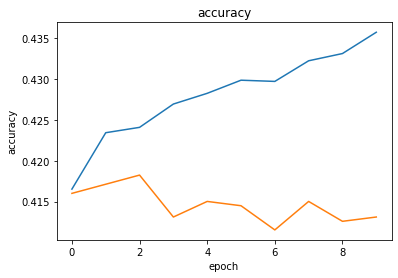

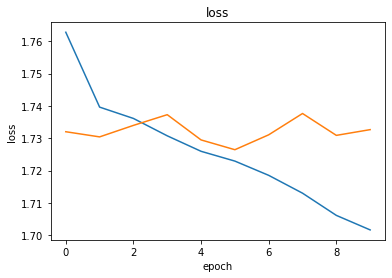

In [15]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

In [14]:
model_inn_1.save('Models/Inn1_LSTM_10.h5')

## Chasing

In [7]:
# del bf_train_gen, bf_test_gen
BS = pd.read_csv("Data/Chasing.csv")
BS_clean = BS.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BS_clean.columns)

Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Target', 'Result'],
      dtype='object')


In [8]:
# BF = pd.read_csv("Data/Batting_First.csv")
window_size = 12
batch_size = 8
bs_train_gen = DataGenerator(BS_clean, window_size, batch_size)
bs_test_gen = DataGenerator(BS_clean, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BS_clean, ((1, 5), (6, 10), (11, 15), (16, 20)),
                                         window_size=window_size,
                                         batch_size=batch_size)

In [9]:
model_inn_2= tf.keras.Sequential([
  # tf.keras.layers.SimpleRNN(512, return_sequences=True, input_shape=(None, bs_test_gen[0][0].shape[-1])),
  tf.keras.layers.Dense(512, input_shape=(None, bs_test_gen[0][0].shape[-1])),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.SimpleRNN(57, return_sequences=False, activation="softmax"),
])
model_inn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 512)         795136    
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 256)         196864    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 64)          20544     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 57)                6

In [10]:
start = 0
epochs = 10
validation_callback = AdditionalValidationSets(validation_sets)
model_inn_2.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_2.fit(bs_train_gen,
                validation_data=bs_test_gen,
                epochs=epochs,
                callbacks=[AdditionalValidationSets(validation_sets)] # , PlotLossesKeras()]
                )

Epoch 1/10
7151/7151 [==============================] - 1023s 143ms/step - loss: 1.7968 - accuracy: 0.3498 - val_loss: 1.7758 - val_accuracy: 0.4014
Epoch 2/10
7151/7151 [==============================] - 984s 138ms/step - loss: 1.7634 - accuracy: 0.3769 - val_loss: 1.7914 - val_accuracy: 0.2904
Epoch 3/10
7151/7151 [==============================] - 980s 137ms/step - loss: 1.7537 - accuracy: 0.3907 - val_loss: 1.7574 - val_accuracy: 0.4110
Epoch 4/10
7151/7151 [==============================] - 1081s 151ms/step - loss: 1.7531 - accuracy: 0.3942 - val_loss: 1.7812 - val_accuracy: 0.2904
Epoch 5/10
  23/7151 [..............................] - ETA: 38:46 - loss: 1.9768 - accuracy: 0.3478

In [26]:
model_inn_2.save('Models/Inn2_SimpleRNN_10.h5')

In [7]:
model_inn_1 = tf.keras.models.load_model('Models/Inn1_SimpleRNN_10.h5')
model_inn_2 = tf.keras.models.load_model('Models/Inn2_SimpleRNN_10.h5')